In [2]:
!git clone https://github.com/Shambu-K/handwriting-generator-model.git
!pip install fastdtw
%cd /kaggle/working/handwriting-generator-model/Code/STR_model

Cloning into 'handwriting-generator-model'...
remote: Enumerating objects: 1406, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 1406 (delta 152), reused 301 (delta 143), pack-reused 1064
Receiving objects: 100% (1406/1406), 332.01 MiB | 26.87 MiB/s, done.
Resolving deltas: 100% (604/604), done.
Updating files: 100% (117/117), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=109872 sha256=bd3123272eb2ab909bbd1c71151d2602efba6298359f0165b7157f594dd13ef8
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
/kaggle/working/handwriting-generator-model/Code/STR_model


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [4]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length):  
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx} | Loss: {loss.item()}')
            
    return loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, data_path, plot=True):
    train_losses = []
    for epoch in range(num_epochs):
        if plot: visualize_progress(model, device, data_path)
        print('=====================================================================\n')
        loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        train_losses.append(loss)
        scheduler.step()
        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/STR_model_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth'):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 100
batch_size = 32 # Archibald it is 32
checkpoint_interval = 1
learning_rate = 0.0001
lr_decay = 0.9

In [6]:
# Load data
root_dir = '/kaggle/input/iam-dataset-online/Resized_Dataset/Train'
dataset = HandwritingDataset(root_dir, batch_size, device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 1370/1370 [00:55<00:00, 24.74it/s]


In [13]:
# Model
model = STR_Model_Longer_512().to(device)
# set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss(sos_weight=20)

Image id: 23110


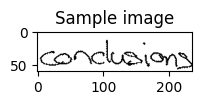

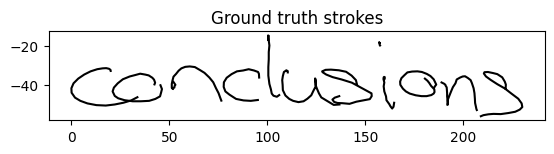

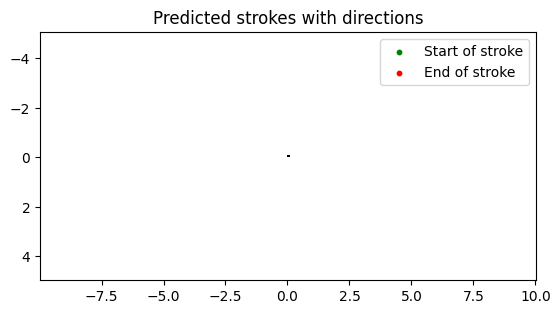

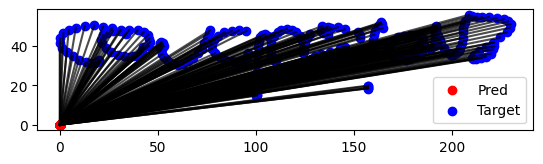

Epoch 1:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1167.5369866881413
   Batch: 100 | Loss: 1065.1498449575247
   Batch: 200 | Loss: 1083.6205728243374
   Batch: 300 | Loss: 1140.7214324564295
   Batch: 400 | Loss: 1229.158410010476
   Batch: 500 | Loss: 1282.7221572828541
   Batch: 600 | Loss: 1442.6635383447815
   Batch: 700 | Loss: 1539.0458938946992
   Batch: 800 | Loss: 1651.43736590418
   Batch: 900 | Loss: 1837.3849732169479
   Batch: 1000 | Loss: 2149.508826031962
   Batch: 1100 | Loss: 2532.830932640873
   Batch: 1200 | Loss: 3061.282875147528
   Batch: 1300 | Loss: 4775.157032444853
Image id: 8211


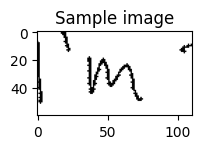

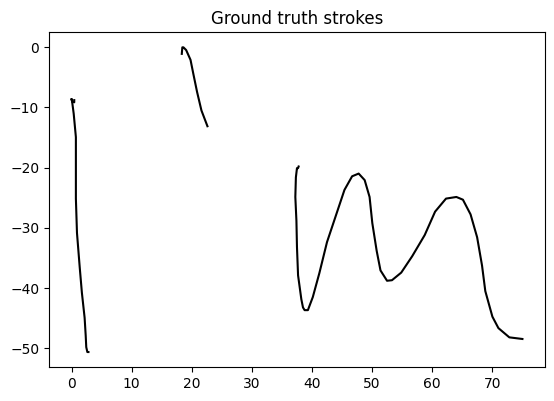

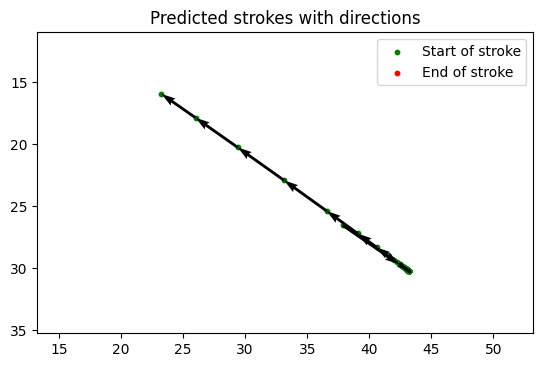

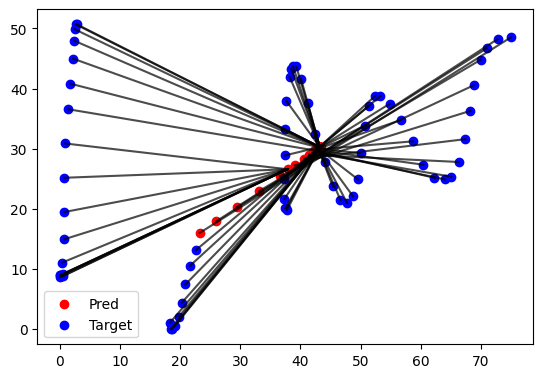

Epoch 2:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1588.4399028842056
   Batch: 100 | Loss: 647.3631538829983
   Batch: 200 | Loss: 706.5871045808293
   Batch: 300 | Loss: 595.2684714527073
   Batch: 400 | Loss: 726.0195301292476
   Batch: 500 | Loss: 817.8003225513091
   Batch: 600 | Loss: 1005.230601294358
   Batch: 700 | Loss: 1087.9522746822704
   Batch: 800 | Loss: 1260.3041118428648
   Batch: 900 | Loss: 1412.2430715230844
   Batch: 1000 | Loss: 1762.8942205469966
   Batch: 1100 | Loss: 2022.6650506961132
   Batch: 1200 | Loss: 2549.0512348416823
   Batch: 1300 | Loss: 4208.12739277015
Image id: 2136


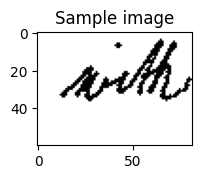

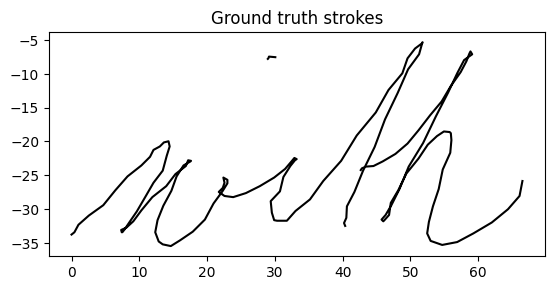

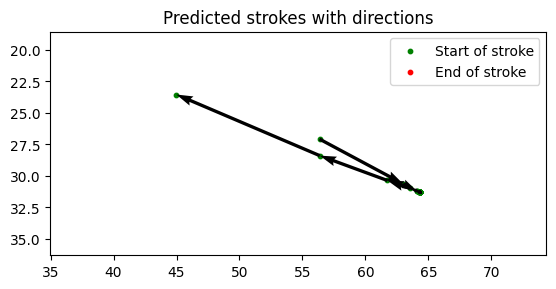

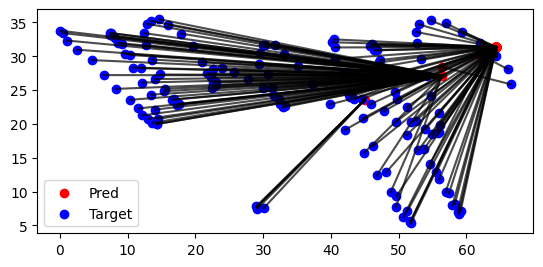

Epoch 3:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1843.035779697138
   Batch: 100 | Loss: 606.3869350969916
   Batch: 200 | Loss: 636.7690219860392
   Batch: 300 | Loss: 569.4102961199111
   Batch: 400 | Loss: 615.2994299513875
   Batch: 500 | Loss: 643.354898680975
   Batch: 600 | Loss: 761.5019103535267
   Batch: 700 | Loss: 838.9199558570156
   Batch: 800 | Loss: 1085.0835566398157
   Batch: 900 | Loss: 1165.5522567613546
   Batch: 1000 | Loss: 1389.6363523276952
   Batch: 1100 | Loss: 1710.032255606838
   Batch: 1200 | Loss: 2193.684338028361
   Batch: 1300 | Loss: 3845.216392085482
Image id: 2033


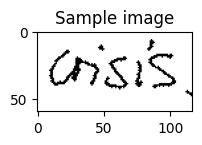

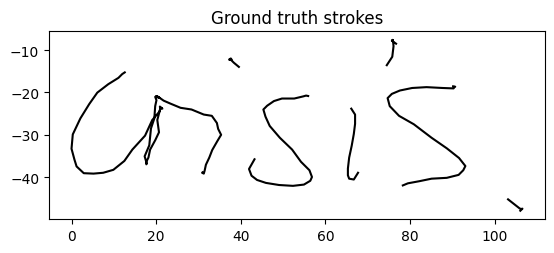

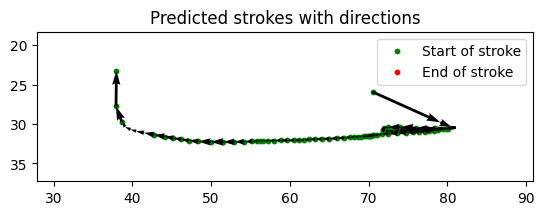

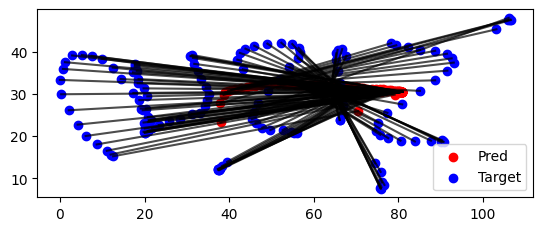

Epoch 4:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1535.2433512235093
   Batch: 100 | Loss: 568.818721795082
   Batch: 200 | Loss: 608.8535720468152
   Batch: 300 | Loss: 568.0763077765266
   Batch: 400 | Loss: 639.0640604245675
   Batch: 500 | Loss: 572.6147623090965
   Batch: 600 | Loss: 785.877712480906
   Batch: 700 | Loss: 775.3906012231398
   Batch: 800 | Loss: 977.1244152083123
   Batch: 900 | Loss: 1039.7969372545117
   Batch: 1000 | Loss: 1157.6696313213579
   Batch: 1100 | Loss: 1491.9568395340846
   Batch: 1200 | Loss: 1933.3137845575616
   Batch: 1300 | Loss: 3491.858663577201
Image id: 24887


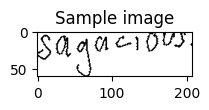

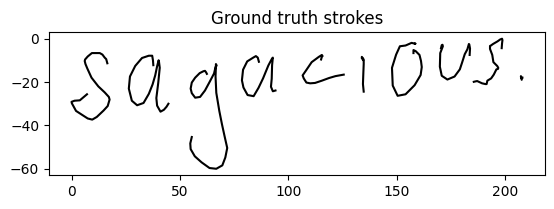

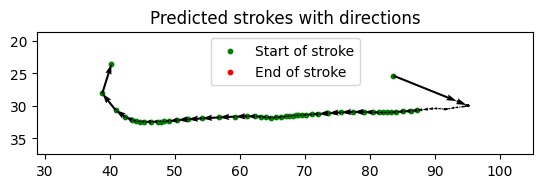

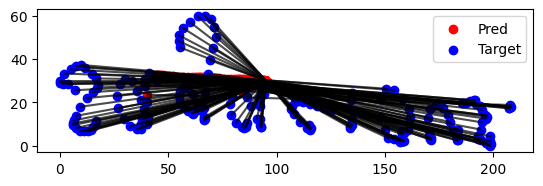

Epoch 5:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1607.1926161475947
   Batch: 100 | Loss: 512.6373879974699
   Batch: 200 | Loss: 595.72569737442
   Batch: 300 | Loss: 557.402797306692
   Batch: 400 | Loss: 606.3786972786617
   Batch: 500 | Loss: 601.2438590379804
   Batch: 800 | Loss: 888.4671680075684
   Batch: 900 | Loss: 907.8562784579075
   Batch: 1000 | Loss: 958.0790769711158
   Batch: 1100 | Loss: 1315.4994139940115
   Batch: 1200 | Loss: 1808.0057415506094
   Batch: 1300 | Loss: 3321.637253273284
Image id: 1712


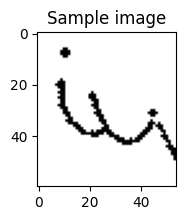

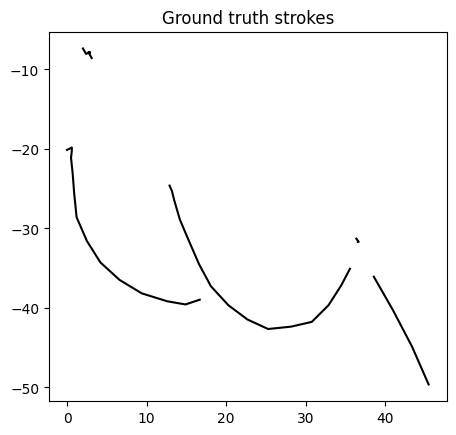

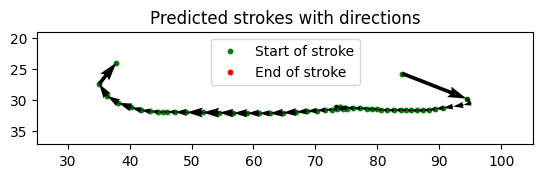

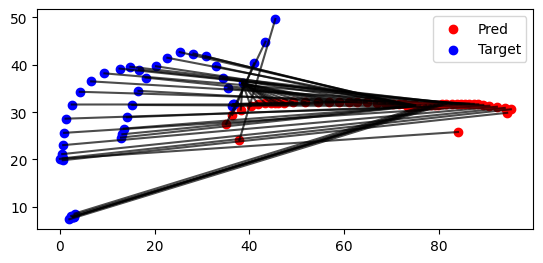

Epoch 6:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1540.935373962863
   Batch: 100 | Loss: 581.5794827399532
   Batch: 200 | Loss: 625.8297248509328
   Batch: 300 | Loss: 540.011962230609
   Batch: 400 | Loss: 610.3569535077422
   Batch: 500 | Loss: 659.7119163153047
   Batch: 600 | Loss: 809.5271674589106
   Batch: 700 | Loss: 863.6366924263028
   Batch: 800 | Loss: 861.8215286751433
   Batch: 900 | Loss: 840.9713419791275
   Batch: 1000 | Loss: 957.9879635319654
   Batch: 1100 | Loss: 1205.2581959665
   Batch: 1200 | Loss: 1694.5874569521877
   Batch: 1300 | Loss: 3081.0726147999403
Image id: 15240


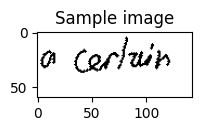

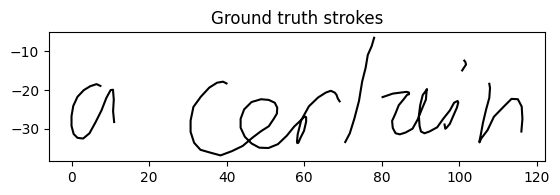

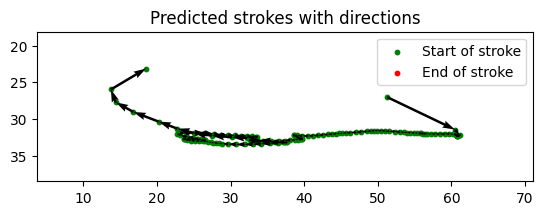

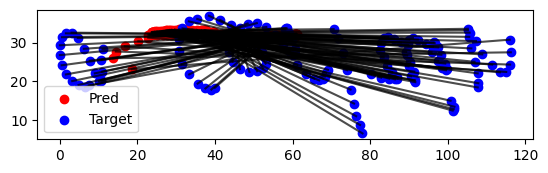

Epoch 7:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 917.7711341879701
   Batch: 100 | Loss: 577.9169745349551
   Batch: 200 | Loss: 624.8232986756176
   Batch: 300 | Loss: 531.0221456540077
   Batch: 400 | Loss: 587.3993381600508
   Batch: 500 | Loss: 656.7312263512816
   Batch: 600 | Loss: 776.9309980522081
   Batch: 700 | Loss: 851.3381593831706
   Batch: 800 | Loss: 909.2857316872328
   Batch: 900 | Loss: 870.8600632553703
   Batch: 1000 | Loss: 897.1839575669443
   Batch: 1100 | Loss: 1107.273336920113
   Batch: 1200 | Loss: 1537.7468329628346
   Batch: 1300 | Loss: 2920.303256779913
Image id: 19267


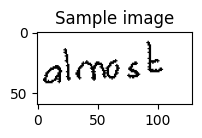

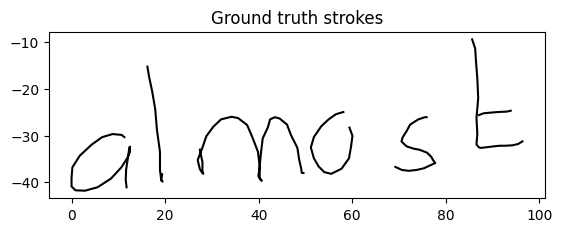

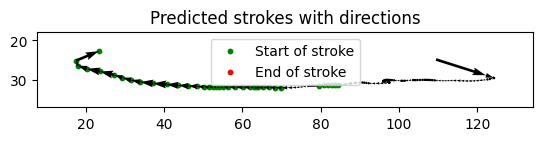

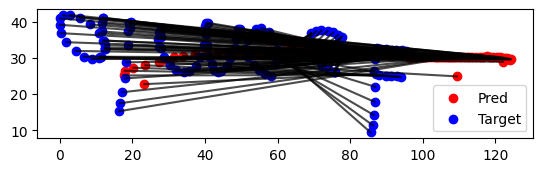

Epoch 8:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 955.3405096437187
   Batch: 100 | Loss: 563.0469151637664
   Batch: 200 | Loss: 621.5252109968343
   Batch: 300 | Loss: 521.8526326945365
   Batch: 400 | Loss: 598.5771913122612
   Batch: 500 | Loss: 656.1226324887656
   Batch: 600 | Loss: 805.0314033586242
   Batch: 700 | Loss: 808.1632066172805
   Batch: 800 | Loss: 891.8389819435822
   Batch: 900 | Loss: 859.5954127837333
   Batch: 1000 | Loss: 820.8995724097844
   Batch: 1100 | Loss: 1042.8762386952158
   Batch: 1200 | Loss: 1425.0026752367198
   Batch: 1300 | Loss: 2785.141251103706
Image id: 26158


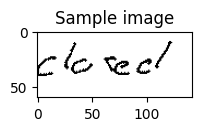

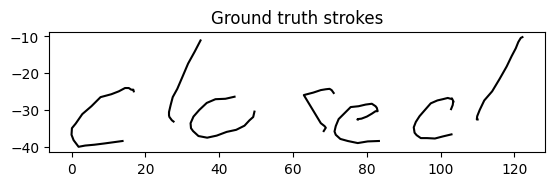

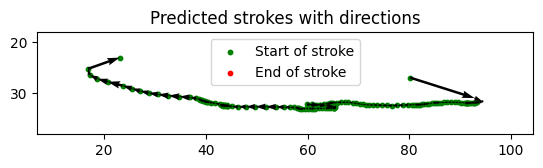

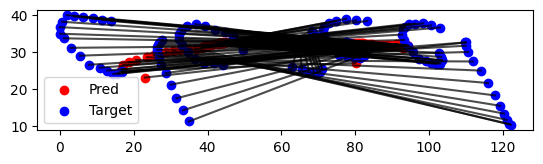

Epoch 9:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 927.7382196292929
   Batch: 100 | Loss: 555.9612883245403
   Batch: 200 | Loss: 621.1922100187292
   Batch: 300 | Loss: 534.7303835871531
   Batch: 400 | Loss: 604.4761973098961
   Batch: 500 | Loss: 616.2857535374468
   Batch: 600 | Loss: 759.418009416419
   Batch: 700 | Loss: 783.0826000874546
   Batch: 800 | Loss: 924.2766048118234
   Batch: 900 | Loss: 892.6214129696834
   Batch: 1000 | Loss: 777.821528755127
   Batch: 1100 | Loss: 1015.0701973965141
   Batch: 1200 | Loss: 1357.8634240353447
   Batch: 1300 | Loss: 2698.7236362482035
Image id: 8046


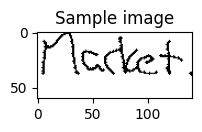

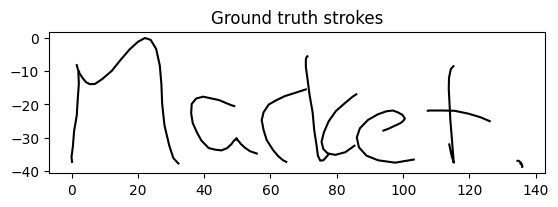

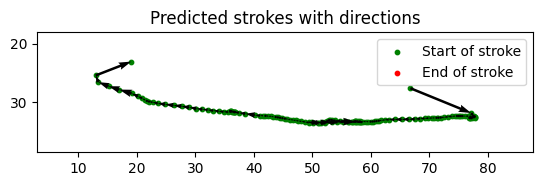

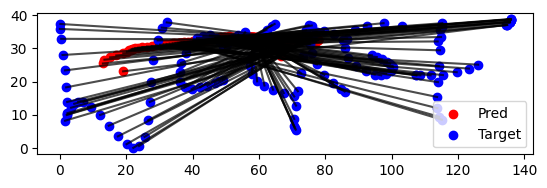

Epoch 10:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 778.3436637867402
   Batch: 100 | Loss: 545.5475967214107
   Batch: 200 | Loss: 586.1271736184127
   Batch: 300 | Loss: 508.1849500566941
   Batch: 400 | Loss: 612.0754762174226
   Batch: 500 | Loss: 625.1348704181852
   Batch: 600 | Loss: 795.9883142474094
   Batch: 700 | Loss: 767.2643690837405
   Batch: 800 | Loss: 923.5905734413191
   Batch: 900 | Loss: 865.1819285169393
   Batch: 1000 | Loss: 743.9828349923118
   Batch: 1100 | Loss: 977.2206779435256
   Batch: 1200 | Loss: 1328.5438616438105
   Batch: 1300 | Loss: 2600.2310074758634
Image id: 6213


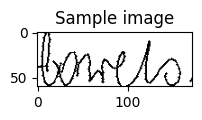

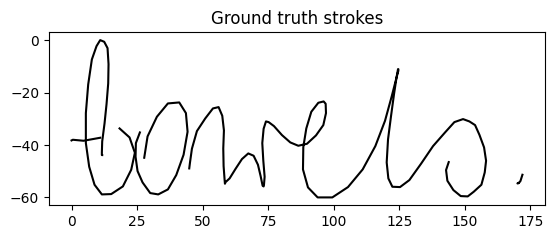

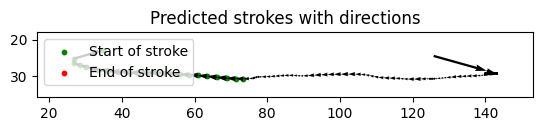

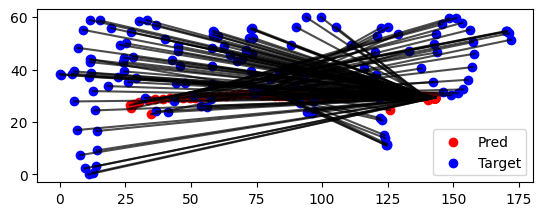

Epoch 11:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 801.7943792310489
   Batch: 100 | Loss: 545.9950487542787
   Batch: 200 | Loss: 568.0882742573389
   Batch: 300 | Loss: 513.1925870217159
   Batch: 400 | Loss: 608.160383528749
   Batch: 500 | Loss: 605.0222853627329
   Batch: 600 | Loss: 766.7306357857125
   Batch: 700 | Loss: 788.5919486148746
   Batch: 800 | Loss: 928.9086909352276
   Batch: 900 | Loss: 880.6639180494303
   Batch: 1000 | Loss: 730.9422703100832
   Batch: 1100 | Loss: 940.0956437683506
   Batch: 1200 | Loss: 1305.0017417175259
   Batch: 1300 | Loss: 2517.2767343490973
Image id: 8301


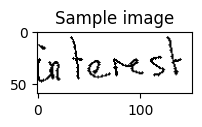

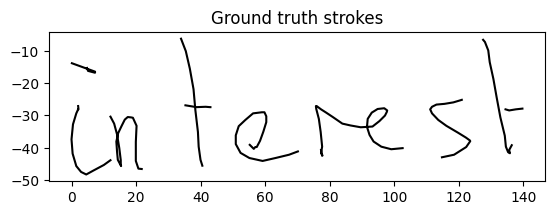

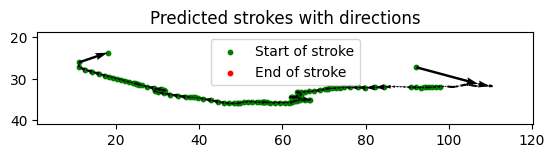

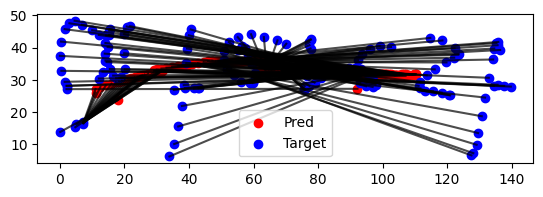

Epoch 12:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 746.7909339855079
   Batch: 100 | Loss: 532.9571726438279
   Batch: 200 | Loss: 565.2628678037968
   Batch: 300 | Loss: 518.4752507254901
   Batch: 400 | Loss: 583.1053277568349
   Batch: 500 | Loss: 587.016665832398
   Batch: 600 | Loss: 758.1475130120349
   Batch: 700 | Loss: 732.8741698589226
   Batch: 800 | Loss: 912.6277018770415
   Batch: 900 | Loss: 865.0214772037389
   Batch: 1000 | Loss: 750.4980107222495
   Batch: 1100 | Loss: 893.5562128883126
   Batch: 1200 | Loss: 1192.9865588136713
   Batch: 1300 | Loss: 2482.7359171406474
Image id: 19437


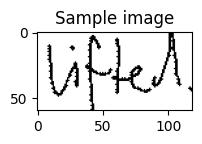

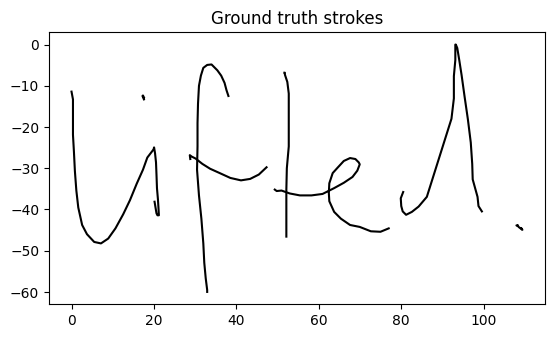

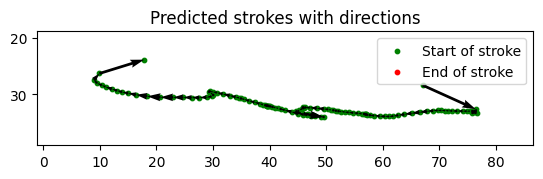

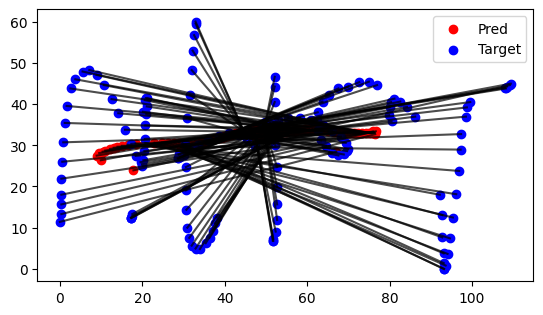

Epoch 13:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 572.738098124136
   Batch: 100 | Loss: 569.869713294297
   Batch: 200 | Loss: 597.7781053911124
   Batch: 300 | Loss: 511.3500318960839
   Batch: 400 | Loss: 573.8259481001513
   Batch: 500 | Loss: 614.6051030602797
   Batch: 600 | Loss: 781.9597274852297
   Batch: 700 | Loss: 765.5266843138882
   Batch: 800 | Loss: 875.7674981286066
   Batch: 900 | Loss: 873.9353670252069
   Batch: 1000 | Loss: 720.7418793752154
   Batch: 1100 | Loss: 930.4837566562206
   Batch: 1200 | Loss: 1193.1005063706336
   Batch: 1300 | Loss: 2410.8134931834666
Image id: 15710


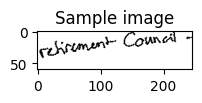

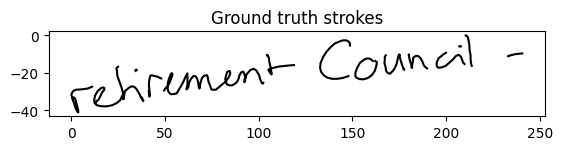

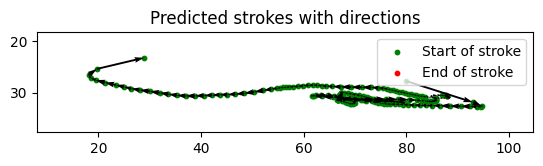

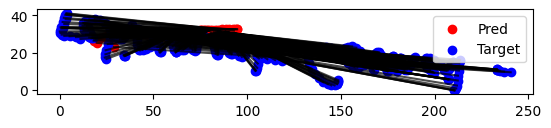

Epoch 14:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 618.3134705843682
   Batch: 100 | Loss: 543.7804326872925
   Batch: 200 | Loss: 593.4663451110702
   Batch: 300 | Loss: 517.8360009199934
   Batch: 400 | Loss: 595.463263065481
   Batch: 500 | Loss: 599.8768667900514
   Batch: 600 | Loss: 783.1053070404314


In [ ]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, root_dir, plot=True)